## Import packages

In [1]:
import os
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
import gzip


## Setup dataset folder

In [2]:
# Change this to your dataset path
DATASET_FOLDER = os.path.abspath("../dataset/")
print(DATASET_FOLDER)

d:\Master_2023\Semester_3\MLATTT\Final\Git\NT221-ML\dataset


## Load Train Dataset

In [3]:
# Load the dataset
train_path = os.path.join(DATASET_FOLDER, "train.csv")
df = pd.read_csv(train_path)

# Basic column names
column_names = [
    'ID', 'flow_duration', 'Header_Length', 'Protocol type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'Label'
]

# Assign column names to the DataFrame
df.columns = column_names
print(df.shape)

# Drop the last row of the DataFrame
df.drop(df.tail(1).index, inplace=True)

(1950138, 48)


In [4]:
# Types of attacks
df['Label'].value_counts()
print(len(df['Label'].unique()))

34


## Drop unnecessary columns

In [5]:
# Drop unnecessary columns from the DataFrame
# 'ID': unique identifier for the event
df = df.drop(columns=['ID'])

## Inspect Dataset 
* Check the first few rows.
* Look for null values and data types.

In [6]:
# Inspect the dataset
print(df.head())

   flow_duration  Header_Length  Protocol type  Duration       Rate  \
0       0.000000          54.00           6.00     64.00   2.890680   
1       0.000892          54.58            NaN     64.00  28.594443   
2       0.000000           0.00           1.00     64.00  23.716061   
3     109.146727        1992.80           8.20     50.10  41.102103   
4       0.025221          58.53           5.95     65.91  25.300629   

       Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0   2.890680    0.0              0.0              0.0              0.0  ...   
1  28.594443    0.0              0.0              1.0              0.0  ...   
2  23.716061    0.0              0.0              0.0              0.0  ...   
3  41.102103    0.0              0.0              0.0              0.0  ...   
4  25.300629    NaN              1.0              0.0              1.0  ...   

          Std  Tot size           IAT  Number   Magnitue      Radius  \
0         NaN     54.00  8

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950137 entries, 0 to 1950136
Data columns (total 47 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   Header_Length    float64
 2   Protocol type    float64
 3   Duration         float64
 4   Rate             float64
 5   Srate            float64
 6   Drate            float64
 7   fin_flag_number  float64
 8   syn_flag_number  float64
 9   rst_flag_number  float64
 10  psh_flag_number  float64
 11  ack_flag_number  float64
 12  ece_flag_number  float64
 13  cwr_flag_number  float64
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        float64
 17  urg_count        float64
 18  rst_count        float64
 19  HTTP             float64
 20  HTTPS            float64
 21  DNS              float64
 22  Telnet           float64
 23  SMTP             float64
 24  SSH              float64
 25  IRC              float64
 26  TCP              float64
 27  UDP         

In [8]:
print(df.describe())

       flow_duration  Header_Length  Protocol type      Duration  \
count   1.950137e+06   1.755125e+06   1.755124e+06  1.755124e+06   
mean    5.994928e+01   2.561773e+05   1.147030e+01  7.428192e+01   
std     9.899799e+02   8.636325e+05   1.157110e+01  2.871633e+01   
min     0.000000e+00   0.000000e+00   0.000000e+00  0.000000e+00   
25%     0.000000e+00   5.400000e+01   6.000000e+00  6.400000e+01   
50%     7.493563e-02   1.790400e+02   6.000000e+00  6.400000e+01   
75%     4.271027e+00   3.354800e+04   1.645000e+01  6.670000e+01   
max     9.968566e+04   9.905298e+06   4.700000e+01  2.550000e+02   

               Rate         Srate         Drate  fin_flag_number  \
count  1.755124e+06  1.755124e+06  1.755124e+06     1.950137e+06   
mean   6.785827e+03  6.750606e+03  8.223636e-06     4.325286e-02   
std    8.137566e+04  8.048462e+04  8.870116e-03     2.034258e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00     0.000000e+00   
25%    3.076981e+00  3.073110e+00  0.000000e+00

## Handle Missing Values
* Drop columns or rows with excessive missing data.
* Impute missing values with mean/median for numeric data or mode for categorical data.

## Explain dataset:
**Basic Identifiers:**
- *ID:* Unique identifier for a network flow.

**Flow Characteristics:**
- *flow_duration:* Total time a network flow lasted.
- *Header_Length*: Size of the packet headers in bytes.
- *Protocol type*: Type of protocol used in the flow.
- *Duration*: Similar to flow_duration
- *Rate*: Data transfer rate during the flow
- *Srate*: Data rate from the source host.
- *Drate*: Data rate toward the destination host.

**TCP Flag Counts:**
- *fin_flag_number*: Number of FIN (finish) flags in the flow.
- *syn_flag_number*: Number of SYN (synchronize) flags in the flow.
- *rst_flag_number*: Number of RST (reset) flags in the flow.
- *psh_flag_number*: Number of PSH (push) flags in the flow.
- *ack_flag_number*: Number of ACK (acknowledge) flags in the flow.
- *ece_flag_number*: Number of ECE (Explicit Congestion Notification Echo) flags in the flow.
- *cwr_flag_number*: Number of CWR (Congestion Window Reduced) flags in the flow.

**Packet Counts:**
- *ack_count*: Total number of acknowledgment packets.
- *syn_count*: Total number of synchronization packets.
- *fin_count*: Total number of finish packets.
- *urg_count*: Total number of urgent packets.
- *rst_count*: Total number of reset packets.

**Protocol-Specific Counters:**
- *HTTP, HTTPS, DNS, Telnet, SMTP, SSH, IRC*:
- *TCP, UDP, DHCP, ARP, ICMP, IPv, LLC*: 
  
**Statistical Features:**
- *Tot sum*: Total sum of packet sizes in the flow.
- *Min*: Minimum packet size in the flow.
- *Max*: Maximum packet size in the flow.
- *AVG*: Average packet size in the flow.
- *Std*: Standard deviation of packet sizes.
- *Tot size*: Total size of all packets in the flow.
- *IAT*: Time interval between consecutive packets.
- *Number*: Total number of packets in the flow.

**Advanced Features:**
- *Magnitue*: Magnitude of traffic flow, sometimes derived from vector analysis.
- *Radius*: Measure of the spatial spread of packets (e.g., in feature space).
- *Covariance*: Covariance of features in the flow.
- *Variance*: Variance of traffic metrics like packet size or timing.
- *Weight*: Weighted importance or significance of the flow.

**Target Variable:**
- *Label*: Indicates if the traffic is malicious or benign. 

In [9]:
# Check for missing values
print("Total: ", len(df))
print(df.isnull().sum())

Total:  1950137
flow_duration           0
Header_Length      195012
Protocol type      195013
Duration           195013
Rate               195013
Srate              195013
Drate              195013
fin_flag_number         0
syn_flag_number         0
rst_flag_number    195013
psh_flag_number    195013
ack_flag_number         0
ece_flag_number    195013
cwr_flag_number    195013
ack_count          195013
syn_count          195012
fin_count               0
urg_count               0
rst_count               0
HTTP               195012
HTTPS              195013
DNS                     0
Telnet             195012
SMTP               195013
SSH                195013
IRC                     0
TCP                195012
UDP                     0
DHCP                    0
ARP                195013
ICMP               195013
IPv                     0
LLC                     0
Tot sum            195012
Min                195013
Max                195013
AVG                     0
Std                195

In [10]:
# Fill missing values for each protocol
protocols = ['TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']

for protocol in protocols:
    if protocol == 'TCP':  # TCP is service-dependent
        df.loc[(df['TCP'].isnull()) & (df[['HTTP', 'HTTPS', 'Telnet', 'SMTP', 'SSH', 'IRC']].sum(axis=1) > 0), 'TCP'] = 1
    elif protocol == 'UDP':  # UDP is service-dependent
        df.loc[(df['UDP'].isnull()) & (df['DNS'] > 0), 'UDP'] = 1
    else:  # Other protocols (ARP, ICMP, etc.)
        df[protocol] = df[protocol].fillna(0)

In [11]:
# Columns to replace NaN with mode value
columns_fill_with_mode = [  'Protocol type',
                            'rst_flag_number', 'psh_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
                            'HTTP', 'HTTPS', 'SMTP', 'SSH', 'TCP', 'ARP', 'ICMP']

df[columns_fill_with_mode] = df[columns_fill_with_mode].apply(lambda col: col.fillna(col.mode()[0]))

# Columns to replace NaN with median value
columns_fill_with_median = ['Duration', 'Rate', 'Srate', 'Drate',
                            'Tot sum', 'Min', "Max", 'Std', 'Tot size', 'IAT',
                            'Magnitue', 'Radius','Covariance', 'Variance']

df[columns_fill_with_median] = df[columns_fill_with_median].apply(lambda col: col.fillna(col.median()))

## Check Unique Values Per Column
* No records is Telnet -> drop

In [12]:
# Calculate the number of unique values and the total number of rows
unique_counts = df.nunique()
total_counts = len(df)

# Create a Series with the ratio of unique values
ratios = unique_counts.astype(str) + '/' + str(total_counts)

# Display the ratios for each column
print(ratios)

flow_duration      1291510/1950137
Header_Length       658743/1950137
Protocol type         4668/1950137
Duration             12353/1950137
Rate               1574314/1950137
Srate              1574080/1950137
Drate                   62/1950137
fin_flag_number          2/1950137
syn_flag_number          2/1950137
rst_flag_number          2/1950137
psh_flag_number          2/1950137
ack_flag_number          2/1950137
ece_flag_number          2/1950137
cwr_flag_number          2/1950137
ack_count              587/1950137
syn_count             1356/1950137
fin_count              993/1950137
urg_count            32231/1950137
rst_count            64085/1950137
HTTP                     2/1950137
HTTPS                    2/1950137
DNS                      2/1950137
Telnet                   1/1950137
SMTP                     2/1950137
SSH                      2/1950137
IRC                      2/1950137
TCP                      2/1950137
UDP                      2/1950137
DHCP                

In [13]:
# Drop unnecessary columns from the DataFrame
# 'Telnet': no records is telnet
df = df.drop(columns=['Telnet'])

## Feature Selection (Using Random Forest)

In [14]:
X = df.drop(['Label'], axis=1)  # Features
y = df['Label']  # Target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

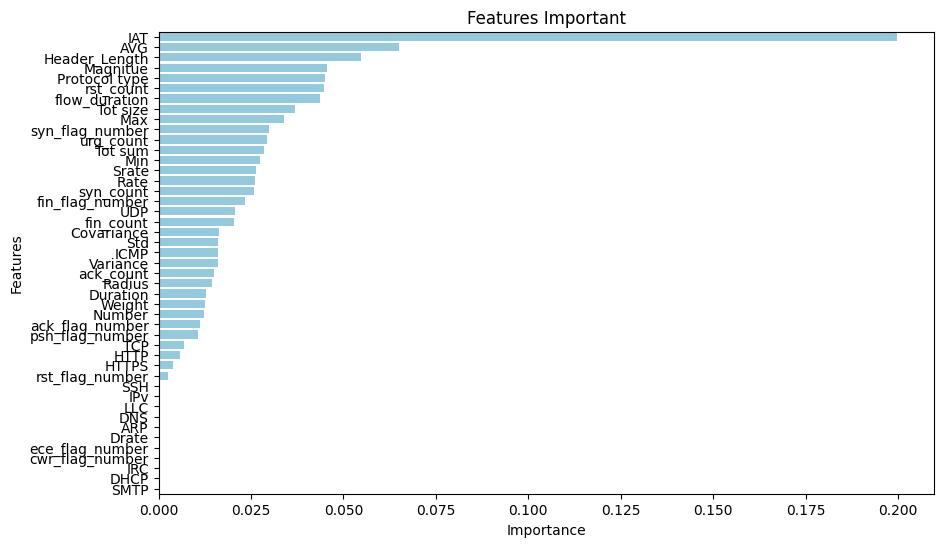

In [70]:
# Feature Importance from Tree-Based Models
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Get feature importance
feature_importances = pd.Series(
    rf.feature_importances_, 
    index=X_train.columns).sort_values(ascending=False)

# Draw figures
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Features Important")
feature_importance_plot = "feature_importance.png"
plt.savefig(feature_importance_plot, bbox_inches='tight')

In [ ]:
# Print the top 20 features
top_20_features = feature_importances.head(20).index.tolist()
print("Top 20 Features:")
print(top_20_features)
# Print drop columns
drop_features = feature_importances.tail(25).index.tolist()
print("Drop Features:")
print(drop_features)

In [17]:
# Select features
select_features = ['IAT', 'AVG', 'Header_Length', 'Magnitue', 'Protocol type', 'rst_count', 'flow_duration', 'Tot size', 'Max', 'syn_flag_number', 'urg_count', 'Tot sum', 'Min', 'Srate', 'Rate', 'syn_count', 'fin_flag_number', 'UDP', 'fin_count', 'Covariance']
drop_features = ['Std', 'ICMP', 'Variance', 'ack_count', 'Radius', 'Duration', 'Weight', 'Number', 'ack_flag_number', 'psh_flag_number', 'TCP', 'HTTP', 'HTTPS', 'rst_flag_number', 'SSH', 'IPv', 'LLC', 'DNS', 'ARP', 'Drate', 'ece_flag_number', 'cwr_flag_number', 'IRC', 'DHCP', 'SMTP']

## Model: XGBoost (Tuning Parameter)

In [18]:
# Select features
select_features = ['IAT', 'AVG', 'Header_Length', 'Magnitue', 'Protocol type', 'rst_count', 'flow_duration', 'Tot size', 'Max', 'syn_flag_number', 'urg_count', 'Tot sum', 'Min', 'Srate', 'Rate', 'syn_count', 'fin_flag_number', 'UDP', 'fin_count', 'Covariance']
drop_features = ['Std', 'ICMP', 'Variance', 'ack_count', 'Radius', 'Duration', 'Weight', 'Number', 'ack_flag_number', 'psh_flag_number', 'TCP', 'HTTP', 'HTTPS', 'rst_flag_number', 'SSH', 'IPv', 'LLC', 'DNS', 'ARP', 'Drate', 'ece_flag_number', 'cwr_flag_number', 'IRC', 'DHCP', 'SMTP']

In [19]:
# Step 1: Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Label'])

# Step 2: Split dataset while preserving class ratios
X = df[select_features]  # Features
y = y_encoded  # Encoded target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Use X_sample and y_sample (10% of the dataset) for quicker experiments.
X_sample, _, y_sample, _ = train_test_split(
    X, y, stratify=y, test_size=0.9, random_state=42
)

# Instantiate the XGBoost Classifier
xgb = XGBClassifier(
    objective='multi:softprob',  # Multiclass classification
    num_class=34,  # Number of classes
    random_state=42
)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [50, 100, None],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # Reduce iterations for quicker results
    cv=3,  # Reduce cross-validation folds
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on sampled data
random_search.fit(X_sample, y_sample)

# Get the best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Training Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 100, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best Training Accuracy: 0.9261741485442885

Test Set Evaluation:
Accuracy: 0.9285435917421313
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.14      0.20       450
           1       0.76      0.85      0.80     16817
           2       0.74      0.43      0.54       827
           3       0.53      0.34      0.42       764
           4       1.00      1.00      1.00     16803
           5       0.97      0.96      0.97      4068
           6       1.00      1.00      1.00     16717
           7       1.00      1.00      1.00     16824
           8       1.00      1.00      1.00     16809
           9       1.00      1.00      1.00     16790
          10       0.95      0.98      0.96     16810
          11 

In [124]:
# Split dataset while preserving class ratios
X = df[select_features]  # Features
y = df['Label']  # Encoded target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [125]:
# Sample 10% of the dataset for quicker experiments
X_sample, _, y_sample, _ = train_test_split(
    X, y, stratify=y, test_size=0.9, random_state=42
)

# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],  # None allows unlimited depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Reduce iterations for quicker results
    cv=3,  # Reduce cross-validation folds
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV on the sampled data
random_search.fit(X_sample, y_sample)

# Get the best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Training Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the evaluation results
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
11 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Best Training Accuracy: 0.9236717486122984

Test Set Evaluation:
Accuracy: 0.9259309588029577
Classification Report:
                         precision    recall  f1-score   support

       Backdoor_Malware       0.98      0.36      0.53       450
          BenignTraffic       0.74      0.86      0.80     16817
       BrowserHijacking       0.95      0.32      0.48       827
       CommandInjection       0.88      0.50      0.64       764
 DDoS-ACK_Fragmentation       1.00      0.99      0.99     16803
        DDoS-HTTP_Flood       0.93      0.95      0.94      4068
        DDoS-ICMP_Flood       1.00      1.00      1.00     16717
DDoS-ICMP_Fragmentation       1.00      0.98      0.99     16824
      DDoS-PSHACK_Flood       1.00      1.00      1.00     16809
       DDoS-RSTFINFlood       1.00      1.00      1.00     16790
         DDoS-SYN_Flood       0.94      0.98

## Model: Decision Tree 

In [126]:
# Select features
select_features = ['IAT', 'AVG', 'Header_Length', 'Magnitue', 'Protocol type', 'rst_count', 'flow_duration', 'Tot size', 'Max', 'syn_flag_number', 'urg_count', 'Tot sum', 'Min', 'Srate', 'Rate', 'syn_count', 'fin_flag_number', 'UDP', 'fin_count', 'Covariance']
drop_features = ['Std', 'ICMP', 'Variance', 'ack_count', 'Radius', 'Duration', 'Weight', 'Number', 'ack_flag_number', 'psh_flag_number', 'TCP', 'HTTP', 'HTTPS', 'rst_flag_number', 'SSH', 'IPv', 'LLC', 'DNS', 'ARP', 'Drate', 'ece_flag_number', 'cwr_flag_number', 'IRC', 'DHCP', 'SMTP']

In [127]:
# Split dataset while preserving class ratios
X = df[select_features]  # Features
y = df['Label']  # Encoded target

In [128]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, n_estimators=100,
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_depth=30,
    bootstrap=False                            )  # You can adjust `n_estimators`

start = time.time()
print('program start...')
print()

# Train the Random Forest model
rf_model.fit(X_train, y_train)
print()

print('prediction:')
# Make predictions
Y_pred = rf_model.predict(X_test)
print(Y_pred)
print()

# Evaluate the model
print('Score:')
score = rf_model.score(X_test, y_test)
print(score)

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


prediction:
['DoS-TCP_Flood' 'DDoS-UDP_Flood' 'BenignTraffic' ... 'DDoS-TCP_Flood'
 'Mirai-greip_flood' 'Mirai-greeth_flood']

Score:
0.9367224917185433
program end...

time cost: 
817.6938591003418 seconds


## Model: XGBoost (Training)

In [21]:
# Select features
select_features = ['IAT', 'AVG', 'Header_Length', 'Magnitue', 'Protocol type', 'rst_count', 'flow_duration', 'Tot size', 'Max', 'syn_flag_number', 'urg_count', 'Tot sum', 'Min', 'Srate', 'Rate', 'syn_count', 'fin_flag_number', 'UDP', 'fin_count', 'Covariance']
drop_features = ['Std', 'ICMP', 'Variance', 'ack_count', 'Radius', 'Duration', 'Weight', 'Number', 'ack_flag_number', 'psh_flag_number', 'TCP', 'HTTP', 'HTTPS', 'rst_flag_number', 'SSH', 'IPv', 'LLC', 'DNS', 'ARP', 'Drate', 'ece_flag_number', 'cwr_flag_number', 'IRC', 'DHCP', 'SMTP']

In [22]:
# Step 1: Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Label'])

# Step 2: Split dataset while preserving class ratios
X = df[select_features]  # Features
y = y_encoded  # Encoded target

In [23]:
# Train the model with the best parameters on the full training data
xgb_model = XGBClassifier(
    objective='multi:softprob',  # For multi-class classification
    num_class=34,               # Ensure this matches your dataset
    random_state=42,
    n_estimators=150,
    max_depth=100
)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, num_class=34,
              num_parallel_tree=None, ...)

In [24]:
# Predict on the test set
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9357020521603577

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.21      0.26       450
           1       0.80      0.86      0.83     16817
           2       0.78      0.52      0.63       827
           3       0.52      0.35      0.42       764
           4       1.00      1.00      1.00     16803
           5       0.98      0.97      0.98      4068
           6       1.00      1.00      1.00     16717
           7       1.00      1.00      1.00     16824
           8       1.00      1.00      1.00     16809
           9       1.00      1.00      1.00     16790
          10       0.95      0.97      0.96     16810
          11       0.97      0.98      0.97      3315
          12       0.99      0.98      0.98     16804
          13       0.97      0.98      0.97     16842
          14       0.98      0.98      0.98     16781
          15       1.00      1.00      1.00     16779
          16       0.76     

In [104]:
# Configure the Random Forest Model
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=500)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# Train the model
rf.fit(X_train, Y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(Y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.43      0.59       450
           1       0.78      0.88      0.83     16817
           2       0.97      0.51      0.67       827
           3       0.95      0.57      0.71       764
           4       1.00      0.99      1.00     16803
           5       0.96      0.97      0.96      4068
           6       1.00      1.00      1.00     16717
           7       1.00      0.99      0.99     16824
           8       1.00      1.00      1.00     16809
           9       1.00      1.00      1.00     16790
          10       0.95      0.97      0.96     16810
          11       0.94      0.97      0.95      3315
          12       0.98      0.97      0.98     16804
          13       0.97      0.98      0.97     16842
          14       0.97      0.98      0.98     16781
          15       1.00      0.99      1.00     16779
          16       0.77      0.78      0.78     16749
    

## TODO: Debug 2 classes
- Benign
- DNS_Spoofing

## Export Model

In [27]:
# Save the trained model for future use
xgb_model.save_model('xgb_model.pkl')

# Compress the saved model
with open('xgb_model.pkl', 'rb') as f_in:
    with gzip.open('xgb_model.gz', 'wb') as f_out:
        f_out.writelines(f_in)
print("Model trained and saved xgb_model.pkl successfully!")

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Model trained and saved xgb_model.pkl successfully!
